# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [2]:
# import packages
import datetime
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [63]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [64]:
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data["time"])

In [65]:
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday

col = ["x", "y", "direction", "hour", "minute", "weekday"]
minute_mean = data.iloc[:len(train)].groupby(col).mean()
minute_mean.columns = ["minute_mean"]
data = data.merge(minute_mean, how="left", left_on=col, right_index=True)

In [66]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [35]:
xs = train.x.unique().tolist()
ys = train.y.unique().tolist()
dirs = train.direction.unique().tolist()

feature_col = ["hour", "minute", "weekday", "minute_mean"]

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

oof_train = np.zeros((len(train), ))
oof_idx = []
all_models = {}
all_y_preds = {}

for x in xs:
    for y in ys:
        for dir in dirs:
            loc_dir = (x, y, dir)
            print("======== loop: {} ========".format(loc_dir))

            locdir_X_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)][feature_col]
            locdir_y_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)]["congestion"]
            locdir_X_test = test[(test.x == x) & (test.y == y) & (test.direction == dir)][feature_col]

            # loc & dir の組み合わせが存在しないときは処理しない
            if locdir_X_train.shape[0] == 0:
                print("{} is nothing".format(loc_dir))
                continue

            cv = TimeSeriesSplit(n_splits=5)

            y_preds = []
            models = []

            for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(locdir_X_train)):
                print(f"======== fold: {fold_idx} ========")
                X_tr, X_val = locdir_X_train.iloc[tr_idx], locdir_X_train.iloc[val_idx]
                y_tr, y_val = locdir_y_train.iloc[tr_idx], locdir_y_train.iloc[val_idx]
                
                lgb_train = lgb.Dataset(X_tr, y_tr)
                lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
                
                model = lgb.train(params, lgb_train,
                                valid_sets=[lgb_train, lgb_eval],
                                verbose_eval=10,
                                num_boost_round=1000,
                                early_stopping_rounds=10)
                
                oof_train[X_val.index] = \
                    model.predict(X_val, num_iteration=model.best_iteration)

                oof_idx += X_val.index.tolist()

                y_pred = model.predict(locdir_X_test, num_iteration=model.best_iteration)

                y_preds.append(y_pred)
                models.append(model)
            
            all_y_preds[loc_dir] = y_preds
            all_models[loc_dir] = models

======== loop: (0, 0, 'EB') ========
======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 8.16738	valid_1's l1: 9.61875
[20]	training's l1: 7.72153	valid_1's l1: 9.5029
[30]	training's l1: 7.48848	valid_1's l1: 9.50013
Early stopping, best iteration is:
[25]	training's l1: 7.58058	valid_1's l1: 9.49325
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 8.80965	valid_1's l1: 9.65446
[20]	training's l1: 8.46567	valid_1's l1: 9.43689
[30]	training's l1: 8.29932	valid_1's l1: 9.35908
[40]	training's l1: 8.21094	valid_1's l1: 9.3519
[50]	training's l1: 8.1628	valid_1's l1: 9.36312
Early stopping, best iteration is:
[41]	training's l1: 8.20439	valid_1's l1: 9.35032
======== fold: 2 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.04909	valid_1's l1: 9.29208
[20]	training's l1: 8.72897	valid_1's l1: 9.00229
[30]	training's l1: 8.60067	vali

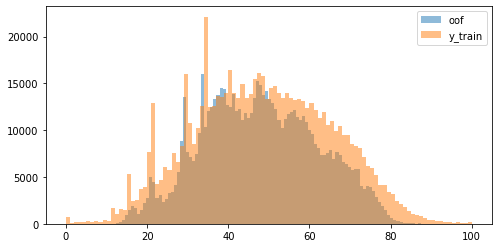

In [42]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[oof_idx], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[oof_idx].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()

In [50]:
scores = {}

for ld, ms in all_models.items():
    scores[ld] = ms[-1].best_score["valid_1"]["l1"]

score = sum(scores.values()) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
{(0, 0, 'EB'): 9.536242064832553, (0, 0, 'NB'): 7.716867549468524, (0, 0, 'SB'): 9.816111474824671, (0, 1, 'EB'): 5.99526104005664, (0, 1, 'NB'): 5.0997126607902805, (0, 1, 'SB'): 5.2621283477194485, (0, 1, 'WB'): 9.020973878182092, (0, 2, 'EB'): 4.679769609927865, (0, 2, 'NB'): 4.8051937575822725, (0, 2, 'SB'): 6.472851686830356, (0, 2, 'WB'): 3.4746688269523576, (0, 3, 'EB'): 6.1809166057472344, (0, 3, 'NB'): 4.296272482344498, (0, 3, 'SB'): 6.520154755106859, (0, 3, 'WB'): 6.275794991779532, (0, 3, 'NE'): 6.910265563125595, (0, 3, 'SW'): 6.552723929470881, (1, 0, 'EB'): 7.42865954624098, (1, 0, 'NB'): 8.636992233390217, (1, 0, 'SB'): 7.875306380842875, (1, 0, 'WB'): 4.652057151980701, (1, 0, 'NE'): 8.951736547306101, (1, 0, 'SW'): 9.389995432684552, (1, 1, 'EB'): 9.870434842390944, (1, 1, 'NB'): 9.049221392059449, (1, 1, 'SB'): 7.033552816045709, (1, 1, 'WB'): 8.026174410840243, (1, 2, 'EB'): 5.762685983819996, (1, 2, 'NB'): 7.045777996949745, (1, 2, 'SB'): 6.09882

In [51]:
with open("../output/all_y_preds_005.pickle", "wb") as f:
    pickle.dump(all_y_preds, f)

with open("../output/all_models_005.pickle", "wb") as f:
    pickle.dump(all_models, f)

with open("../output/oof_train_005.pickle", "wb") as f:
    pickle.dump(oof_train, f)

with open("../output/oof_idx_005.pickle", "wb") as f:
    pickle.dump(oof_idx, f)

In [88]:
sub_pred = test.copy()[["x", "y", "direction", "congestion"]]

In [93]:
for (x, y, dir), y_preds in all_y_preds.items():
    sub_pred.loc[((test.x == x) & (test.y == y) & (test.direction == dir)), ["congestion"]] = y_preds[-1]

array([46.14433971, 37.60018932, 54.29679107, ..., 70.99137817,
       17.11532365, 39.39749533])

In [94]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = sub_pred.congestion.to_numpy()
submission.to_csv("../submit/submission_005.csv", index=False)

### submit

In [95]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [96]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_005.csv -m "005"

100% 57.5k/57.5k [00:02<00:00, 22.3kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022